# Home Battery Analyzer
Use data collected from your digital electricity meter via dsmr-reader, and from your solar panels via SolarEdge, to analyze the business case for a home battery. Also, look into self-consumption and self-sufficiency.

In [ ]:
%reset -f

## Set-up

### Load configuration data

_Fill in your personal details, logins and **passwords** in the .env file._

In [ ]:
from dotenv import load_dotenv
import os

# Load variables from .env file
load_dotenv();

### Analysis time period and resolution
_Change below **start date** depending on your situation_

Note: dsmr data is typically available per minute, but the SolarEdge data is only available per 15-minute period.

In [ ]:
import datetime

# Period for the analysis
# Change below depending on your situation
START_ANALYSIS = datetime.datetime(2021, 3, 16)
END_ANALYSIS = datetime.datetime.now()

display([START_ANALYSIS, END_ANALYSIS])

In [ ]:
# Time resolution
TIME_RESOLUTION = 15 #Quarter of an hour, in minutes. Use as TIME_RESOLUTION / 60.

### Get timezone and details of site
To be able to interpret time data correctly, we need to know the timezone of the house. The easiest way is to get this from SolarEdge. Assumption is that timezone is correct in the SolarEdge account.

In [ ]:
import requests

URL='https://monitoringapi.solaredge.com'
sub_url='/site/'+str(os.getenv('SOLAREDGE_SITE_ID'))+'/details'
params = {'api_key': os.getenv('SOLAREDGE_SITE_API_KEY')}

# Get site details from SolarEdge and print url for debugging
r = requests.get(URL+sub_url, params=params)
print(r.url)
r.raise_for_status()

In [ ]:
# Get the name and address and print it, for completeness/verification.
name = r.json()['details']['name']
location = r.json()['details']['location']
if not 'state' in location:
    location['state'] = ''
print(name + ': \n')
print(location['address'] + ', ' + location['address2'] + ', \n')
print(location['zip'] + ', ' + location['city'] + ', ' + location['state'] + ', ' + location['country'])

In [ ]:
# Get the timezone and print it
timezone = r.json()['details']['location']['timeZone']
print(timezone)

### First definitions: important parameters
The following parameters are important to keep an eye on in optimizing your installation:

The self-consumption ratio - or **self-consumption** - is the share of the produced (e.g. solar) energy which is instantaneously consumed in the household load: 

$$\text{self-consumption} = \frac{\text{self-consumed produced energy}}{\text{total produced energy}}$$

The self-sufficiency ratio - or **self-sufficiency** - is the share of the demanded energy which can be instantaneously provided by household production:

$$\text{self-sufficiency} = \frac{\text{self-produced demanded energy}}{\text{total demanded energy}}$$

Energy is expressed in kWh in this document. Power is expressed in kW.

## The electricity network
The house is connected to the electricity network. All houses pull energy from it to run the lights, appliances, heating etc. Houses with solar panels also send superfluous energy to the network. 

For the analysis, data is collected from the digital meter (dsmr database) about this. 

In Flanders, as of 2021 with a digital meter and solar panels, the tariff distinguishes pulling and sending energy.

### Definitions related to network

The **imported energy** is the energy pulled (bought) from the electricity network, or from the point of view of the network, the energy delivered to the household.

The **exported energy** is the energy sent (sold) to the electricity network, or from the point of view of the network, the energy returned by the household.

### Access to dsmr-reader database

In [ ]:
import psycopg2

# Connecting to the database
connection = psycopg2.connect(database=os.getenv('PGSQL_DB'), user=os.getenv('PGSQL_USER'), password=os.getenv('PGSQL_PASS'), port=os.getenv('PGSQL_PORT'), host=os.getenv('PGSQL_HOST'))

# Instantiating the cursor
cursor = connection.cursor()

In [ ]:
# Quick connection check
cursor.execute("SELECT version();")
record = cursor.fetchone()
print("You are connected to - ", record, "\n")

### Get energy data per time resolution
**`imported`** and **`exported`** are the (summed) energies of the period (e.g. per 15-minute time period).

`meter_imported` and `meter_exported` are the readouts of the meter, i.e. cumulative.

The timestamps are in the time zone of the site of the installation.

Assumption here is that data is complete (no missing timestamps), and perfectly aligned with the 0'th minute and second. 

Note that because we are subtracting two cumulative measurements, we miss the first time period (e.g. first 15 minutes).
Note: For legacy reasons, energies per period are being read out, instead of powers. While power measurements are simpler, it's not clear which data would be more correct and complete.

In [ ]:
import pandas as pd
import pandas.io.sql as sqlio

# Query for energy data from dsmr-reader
query = """
SELECT 
    nested.time,
    nested.meter_imported,
    nested.meter_exported,
    nested.meter_imported - lag(nested.meter_imported) over (ORDER BY nested.time) as imported,
    nested.meter_exported - lag(nested.meter_exported) over (ORDER BY nested.time) as exported
FROM 
    (SELECT 
        to_timestamp(floor((extract('epoch' from timestamp) / (%s*60) )) * (%s*60)) AT TIME ZONE %s as time,
        min(electricity_delivered_1+electricity_delivered_2) as meter_imported, 
        min(electricity_returned_1+electricity_returned_2) as meter_exported
    FROM public.dsmr_datalogger_dsmrreading
    WHERE timestamp>%s AND timestamp<%s
    GROUP BY time
    ORDER BY time ASC) as nested
ORDER BY time ASC OFFSET 1 ROWS;
"""
params = [TIME_RESOLUTION, TIME_RESOLUTION, timezone, START_ANALYSIS, END_ANALYSIS]

# Get query data into a pandas DataFrame (data table)
data = sqlio.read_sql_query(sql=query, con=connection, params=params)
data.set_index('time', inplace=True)

# Show data
display(data)

### What was imported and exported?

In [ ]:
# Calculate totals
def calculate_totals(data):
    imported_during_timeframe = data['meter_imported'].iloc[-1] - data['meter_imported'].iloc[0]
    exported_during_timeframe = data['meter_exported'].iloc[-1] - data['meter_exported'].iloc[0]
    
    energy_during_timeframe = pd.Series([imported_during_timeframe, exported_during_timeframe], index=['imported', 'exported'], name="Energy from/to network [kWh]")
    print(energy_during_timeframe)
    
    return (imported_during_timeframe, exported_during_timeframe, energy_during_timeframe)
    
(imported_during_timeframe, exported_during_timeframe, energy_during_timeframe) = calculate_totals(data)

In [ ]:
# Calculate totals differently
def calculate_totals_differently(data):
    imported_during_timeframe = data['imported'].sum()
    exported_during_timeframe = data['exported'].sum()
    
    energy_during_timeframe = pd.Series([imported_during_timeframe, exported_during_timeframe], index=['imported', 'exported'], name="Energy from/to network [kWh]")
    print(energy_during_timeframe)
    
    return (imported_during_timeframe, exported_during_timeframe, energy_during_timeframe)

In [ ]:
import matplotlib.pyplot as plt
from cycler import cycler

# Show totals
def show_totals_as_pie_chart(ax, data, imported_during_timeframe, exported_during_timeframe, energy_during_timeframe):
    
    SIZE=0.3
    ax.set_prop_cycle(cycler(color=['#fab9ba', '#aceacd']))
    _, texts, autotexts = ax.pie(energy_during_timeframe, labels=energy_during_timeframe.index, radius=1, startangle=270, 
           wedgeprops=dict(width=SIZE, edgecolor='w', linewidth=3), normalize=True, autopct='%1.1f%%', pctdistance=0.83)

    ax.pie([imported_during_timeframe + exported_during_timeframe], radius=1-SIZE, startangle=270,
           wedgeprops=dict(width=SIZE/2, color='#acd3fa', edgecolor='w', linewidth=3), normalize=True)
    ax.set(aspect="equal")
    ax.text(0, 0.1, "{:.2f}".format(imported_during_timeframe + exported_during_timeframe), ha='center', va='center', size=48, weight="bold")
    ax.text(0, -0.1, "kWh", ha='center', va='center', size=32, weight="bold")
    title_text = ax.set_title(energy_during_timeframe.name)
    plt.setp(title_text, size='xx-large')
    plt.setp(texts, size='x-large')
    plt.setp(autotexts, size=32, weight="bold")
    return plt
    
_, ax = plt.subplots(figsize=(10, 10))
show_totals_as_pie_chart(ax, data, imported_during_timeframe, exported_during_timeframe, energy_during_timeframe).show()

## The solar panel production
For the analysis, data is collected from the solar panel power inverter (from your site account on the SolarEdge server). This data will complement the network data. Therefore data of the same time resolution is collected, and timestamps are aligned. 

<a href="http://www.solaredge.com/">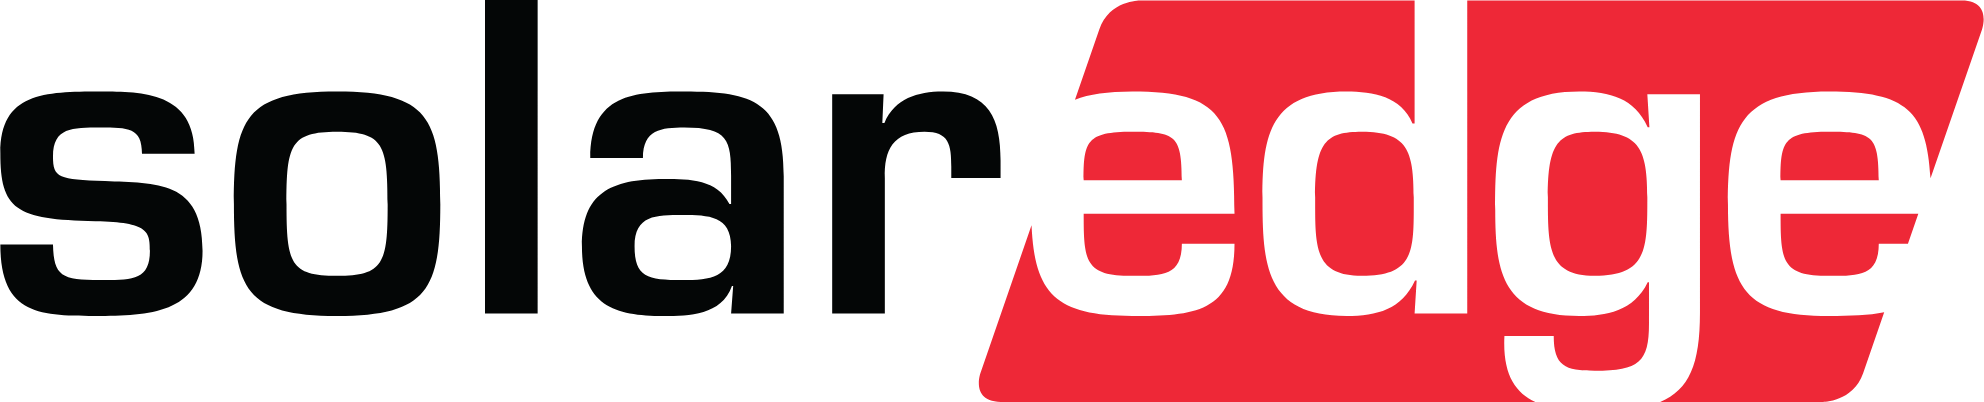</img></a>

Note that this detailed data can only be requested per month period at a time, and therefore we need to make several requests typically.
Note that the inverter seems to be slower in registering the data than the digital meter. Empirically I found that the data aligns best when shifted by 15 minutes.

In [ ]:
def request_data_solar(start_time, end_time):
    sub_url='/site/'+str(os.getenv('SOLAREDGE_SITE_ID'))+'/energy'
    params = {'startDate': start_time.strftime('%Y-%m-%d'), 'endDate': end_time.strftime('%Y-%m-%d'), 'timeUnit': 'QUARTER_OF_AN_HOUR', 'api_key': os.getenv('SOLAREDGE_SITE_API_KEY')}

    # Get data from SolarEdge
    r = requests.get(URL+sub_url, params=params)
    print(r.url)
    r.raise_for_status()
    return r

In [ ]:
def parse_data_solar(r):
    # Parse data
    data_solar = pd.DataFrame(r.json()['energy']['values']) 
    data_solar.rename(columns={"date": "time", "value": "solar_produced"}, inplace=True)
    data_solar['time'] = pd.to_datetime(data_solar['time'])
    
    # Shift by 15mins to match the data
    data_solar['time'] = data_solar.apply(lambda x: x['time'] + datetime.timedelta(minutes=15), axis = 1)
    
    # Correctly represent data
    data_solar.set_index('time', inplace=True)
    data_solar.replace(float('nan'), 0, inplace=True)
    data_solar = data_solar / 1000 #Bring unit form Wh to kWh
    
    return data_solar

In [ ]:
# Get data month by month, each time printing the url. The data is appended and printed.
DELTA = datetime.timedelta(days=30) #1 month
start_time = START_ANALYSIS
data_solar = pd.DataFrame()
while start_time <= END_ANALYSIS:
    end_time = start_time + DELTA
    if end_time > END_ANALYSIS:
        end_time = END_ANALYSIS
        
    r = request_data_solar(start_time, end_time)
    if data_solar.empty:
        data_solar = parse_data_solar(r)
    else:
        data_solar.append(parse_data_solar(r), inplace=True)
    
    start_time += DELTA
    
# Show
display(data_solar)

In [ ]:
# Add to main tabel
data = data.join(data_solar, how='inner')

### Derive the household load
**`solar_produced`** is the energy produced by the solar panels per time period.

There is one more parameter, for which we have no meter:
**`load_consumed`** is the energy consumed by the household per time period, e.g. lights, appliances, heating etc.

But because the 4 parameters need to be in balance, and we have 3 of them, we can derive the consumed load.

Note that due to measurement error and incorrectly aligned or summed data, the derived parameter has some error. Because we cannot accept a negative value, the sum of all parameters will not always be exactly zero, and some totals will be off a bit.

In [ ]:
# Calculate load_used
data['load_consumed'] = data.apply(lambda x: max(0, x['solar_produced'] - x['exported'] + x['imported']), axis = 1)

# Add other future columns
data['battery_state'] = 0
data['battery_produced'] = 0
data['battery_consumed'] = 0

# Show
display(data)

## Visualizing the current state

### Detailed energy graphs over time
These graphs allow to understand at which moment of the day there is a surplus of energy. It's important to understand that depending on season, weather, behavior, and solar production, these graphs can vary a lot. They serve as a basis for more complicated patterns later when we add the battery.

Also shown are the self-consumed solar produced energy and self-produced load consumed energy, contributing respectively to self-consumption and self-sufficiency. Without a battery, these are identical.

In [ ]:
# How many days to show in graphs. These graphs show this many days up until the date of today.
DAYS = 2

In [ ]:
from matplotlib import ticker

# Energy time chart
def show_energy_time_chart(ax, data, title, fill_full=None, fill_hatched=None):
    ax.set_xlim(datetime.datetime.now() - datetime.timedelta(days=DAYS), datetime.datetime.now())
    ax.set_xlabel("time", fontsize='x-large')
    ax.plot('load_consumed', data=data, c='b', label="consumed energy for load [kWh]")
    ax.plot('solar_produced', data=data, c='g', label="produced energy from solar [kWh]")
    if fill_full is not None:
        ax.fill_between(data.index, fill_full)
    if fill_hatched is not None:
        ax.fill_between(data.index, fill_hatched, alpha=0.5, hatch='O')
    title_text = ax.set_title(title)
    plt.setp(title_text, size='xx-large')
    ax.legend(fontsize='x-large')
    ax.minorticks_on()
    return plt

In [ ]:
# Show energy consumption versus production  
fig, ax = plt.subplots(figsize=(30, 10))
show_energy_time_chart(ax, data, 'Energy consumption versus production for %s days' % DAYS).show()

In [ ]:
# Quick check if totals approximately add up after imprecise derivation of load_consumed
assert abs((data['solar_produced'].sum()-data['load_consumed'].sum()+data['imported'].sum()-data['exported'].sum())/(data['imported'].sum()+data['exported'].sum())) < 0.01, "Data matching error is too big"

In [ ]:
# Calculate consumed_solar_produced
data['consumed_solar_produced'] = data.apply(lambda x: max(0, min(x['solar_produced'], x['load_consumed'])), axis = 1)

# Show self-consumed solar produced energy  
fig, ax = plt.subplots(figsize=(30, 10))
show_energy_time_chart(ax, data, 'Self-consumed solar produced energy', data['consumed_solar_produced']).show()

In [ ]:
# Calculate produced_load_consumed
data['produced_load_consumed'] = data.apply(lambda x: max(0, min(x['solar_produced'], x['load_consumed'])), axis = 1)

# Show self-produced load consumed energy 
fig, ax = plt.subplots(figsize=(30, 10))
show_energy_time_chart(ax, data, 'Self-produced load consumed energy', data['produced_load_consumed']).show()

### Show self-consumption and self-sufficiency

In [ ]:
#C alculate self-consumption
self_consumption = data['consumed_solar_produced'].sum()/data['solar_produced'].sum()
print("{:.1%}".format(self_consumption))
print([data['solar_produced'].sum(), data['exported'].sum(), data['consumed_solar_produced'].sum(), data['exported'].sum()+data['consumed_solar_produced'].sum()])

# Show self-consumption
def show_production_as_pie_chart(ax, data):
    battery_production = pd.Series([data['exported'].sum(), data['consumed_solar_produced'].sum(), data['battery_produced'].sum()], index=['', '', 'battery'], name="Energy production [kWh]")
    production = pd.Series([data['exported'].sum(), data['consumed_solar_produced'].sum() + data['battery_produced'].sum()], index=['exported', 'self-consumption'], name="Energy production [kWh]")
    total_produced = data['solar_produced'].sum()

    SIZE=0.3
    if data['battery_produced'].sum() != 0:
        ax.set_prop_cycle(cycler(color=['w', 'w', '#acd3fa']))
        _, battery_texts, battery_autotexts = ax.pie(battery_production, labels=battery_production.index, radius=1.2, startangle=270, 
               wedgeprops=dict(width=SIZE, edgecolor='w', linewidth=3), normalize=True, autopct='%1.1f%%', pctdistance=0.92)
        plt.setp(battery_texts, size='medium')
        plt.setp(battery_autotexts, size=16, weight="bold")
        battery_autotexts[0].set_alpha(0)
        battery_autotexts[1].set_alpha(0)
    ax.set_prop_cycle(cycler(color=['#aceacd', '#acd3fa']))
    _, texts, autotexts = ax.pie(production, labels=production.index, radius=1, startangle=270, 
           wedgeprops=dict(width=SIZE, edgecolor='w', linewidth=3), normalize=True, autopct='%1.1f%%', pctdistance=0.83)
    ax.pie([total_produced], radius=1-SIZE, startangle=270,
           wedgeprops=dict(width=SIZE/2, color='#71eeb6', edgecolor='w', linewidth=3), normalize=True)
    ax.set(aspect="equal")
    ax.text(0, 0.1, "{:.2f}".format(total_produced), ha='center', va='center', size=48, weight="bold")
    ax.text(0, -0.1, "kWh", ha='center', va='center', size=32, weight="bold")
    title_text = ax.set_title(production.name)
    plt.setp(title_text, size='xx-large')
    plt.setp(texts, size='x-large')
    plt.setp(autotexts, size=32, weight="bold")
    return plt
    
_, ax = plt.subplots(figsize=(10, 10))
show_production_as_pie_chart(ax, data).show()

In [ ]:
# Calculate self-sufficiency
self_sufficiency = data['produced_load_consumed'].sum()/data['load_consumed'].sum()
print("{:.1%}".format(self_sufficiency))
print([data['load_consumed'].sum(), data['imported'].sum(), data['produced_load_consumed'].sum(), data['imported'].sum()+data['produced_load_consumed'].sum()])

# Show self-sufficiency
def show_consumption_as_pie_chart(ax, data):
    battery_consumption = pd.Series([data['exported'].sum(), data['consumed_solar_produced'].sum(), data['battery_consumed'].sum()], index=['', '', 'battery'], name="Energy consumption [kWh]")
    consumption = pd.Series([data['imported'].sum(), data['produced_load_consumed'].sum() + data['battery_consumed'].sum()], index=['imported', 'self-sufficiency'], name="Energy consumption [kWh]")
    total_consumed = data['load_consumed'].sum()

    SIZE=0.3
    if data['battery_consumed'].sum() != 0:
        ax.set_prop_cycle(cycler(color=['w', 'w', '#acd3fa']))
        _, battery_texts, battery_autotexts = ax.pie(battery_consumption, labels=battery_consumption.index, radius=1.2, startangle=270, 
               wedgeprops=dict(width=SIZE, edgecolor='w', linewidth=3), normalize=True, autopct='%1.1f%%', pctdistance=0.92)
        plt.setp(battery_texts, size='medium')
        plt.setp(battery_autotexts, size=16, weight="bold")
        battery_autotexts[0].set_alpha(0)
        battery_autotexts[1].set_alpha(0)
    ax.set_prop_cycle(cycler(color=['#fab9ba', '#acd3fa']))
    _, texts, autotexts = ax.pie(consumption, labels=consumption.index, radius=1, startangle=270, 
           wedgeprops=dict(width=SIZE, edgecolor='w', linewidth=3), normalize=True, autopct='%1.1f%%', pctdistance=0.83)
    ax.pie([total_consumed], radius=1-SIZE, startangle=270,
           wedgeprops=dict(width=SIZE/2, color='#f57376', edgecolor='w', linewidth=3), normalize=True)
    ax.set(aspect="equal")
    ax.text(0, 0.1, "{:.2f}".format(total_consumed), ha='center', va='center', size=48, weight="bold")
    ax.text(0, -0.1, "kWh", ha='center', va='center', size=32, weight="bold")
    title_text = ax.set_title(consumption.name)
    plt.setp(title_text, size='xx-large')
    plt.setp(texts, size='x-large')
    plt.setp(autotexts, size=32, weight="bold")
    return plt

_, ax = plt.subplots(figsize=(10, 10))
show_consumption_as_pie_chart(ax, data).show()

### Summary: current state (without battery)

In [ ]:
# Summary report current state without battery
from matplotlib import gridspec

def plot_report_without_battery(data):
    fig = plt.figure(figsize=(30, 40))
    gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 1, 1, 1])

    ax_energy = fig.add_subplot(gs[0, 0])
    ax_production = fig.add_subplot(gs[0, 1])
    ax_consumption = fig.add_subplot(gs[0, 2])

    ax_energy_time_chart = fig.add_subplot(gs[1, :])
    ax_self_consumption_time_chart = fig.add_subplot(gs[2, :])
    ax_self_sufficiency_time_chart = fig.add_subplot(gs[3, :])

    show_totals_as_pie_chart(ax_energy, data, imported_during_timeframe, exported_during_timeframe, energy_during_timeframe)
    show_production_as_pie_chart(ax_production, data)
    show_consumption_as_pie_chart(ax_consumption, data)
    show_energy_time_chart(ax_energy_time_chart, data, 'Energy consumption versus production for %s days' % DAYS)
    show_energy_time_chart(ax_self_consumption_time_chart, data, 'Self-consumed solar produced energy', data['consumed_solar_produced'])
    show_energy_time_chart(ax_self_sufficiency_time_chart, data, 'Self-produced load consumed energy', data['produced_load_consumed'])
    plt.show()

In [ ]:
# Show
plot_report_without_battery(data)

## Adding a battery
We can make simulations of what adding a battery of a certain size would accomplish.

### Get power data per time resolution
Since batteries are not only limited by their size, but also by their charging and discharging power limits, it is useful to also get the power data from both the digital meter and the solar panel inverter.

Counterparts to the energy parameters, the power parameters are the average power per time period.

See remarks about the collection of data above. There is an extra error when the power data does not align or sum correctly with/to the energy data, or when it is not complete.

In [ ]:
# Query for power data from dsmr-reader
query = """
SELECT 
    to_timestamp(floor((extract('epoch' from timestamp) / (60*%s) )) * (60*%s)) AT TIME ZONE %s as time,
    avg(electricity_currently_delivered) as power_import, 
    avg(electricity_currently_returned) as power_export
FROM public.dsmr_datalogger_dsmrreading
WHERE timestamp>%s AND timestamp<%s
GROUP BY time
ORDER BY time ASC
"""
params = [TIME_RESOLUTION, TIME_RESOLUTION, timezone, START_ANALYSIS, END_ANALYSIS]

# Get query data into a pandas DataFrame (data table)
power_data = sqlio.read_sql_query(sql=query, con=connection, params=params)
power_data.set_index('time', inplace=True)

# Show data
display(power_data)

In [ ]:
# Close connection
connection = None

In [ ]:
def request_power_data_solar(start_time, end_time):
    sub_url='/site/'+str(os.getenv('SOLAREDGE_SITE_ID'))+'/power'
    params = {'startTime': start_time.strftime('%Y-%m-%d %H:%M:%S'), 'endTime': end_time.strftime('%Y-%m-%d %H:%M:%S'), 'api_key': os.getenv('SOLAREDGE_SITE_API_KEY')}

    # Get data from SolarEdge
    r = requests.get(URL+sub_url, params=params)
    print(r.url)
    r.raise_for_status()
    return r

In [ ]:
def parse_power_data_solar(r):
    # Parse data
    assert(r.json()['power']['timeUnit'] == 'QUARTER_OF_AN_HOUR')
    power_data_solar = pd.DataFrame(r.json()['power']['values']) 
    power_data_solar.rename(columns={"date": "time", "value": "power_solar_production"}, inplace=True)
    power_data_solar['time'] = pd.to_datetime(power_data_solar['time'])
    power_data_solar

    # Shift by 15mins to match the data
    power_data_solar['time'] = power_data_solar.apply(lambda x: x['time'] + datetime.timedelta(minutes=15), axis = 1)
    
    # Correctly represent data
    power_data_solar.set_index('time', inplace=True)
    power_data_solar.replace(float('nan'), 0, inplace=True)
    power_data_solar = power_data_solar / 1000 #Bring unit from W to kW
    return power_data_solar

In [ ]:
# Get data month by month, each time printing the url. The data is appended and printed.
DELTA = datetime.timedelta(days=30)
start_time = START_ANALYSIS
power_data_solar = pd.DataFrame()
while start_time <= END_ANALYSIS:
    end_time = start_time + DELTA
    if end_time > END_ANALYSIS:
        end_time = END_ANALYSIS
        
    r = request_power_data_solar(start_time, end_time)
    if power_data_solar.empty:
        power_data_solar = parse_power_data_solar(r)
    else:
        power_data_solar.append(parse_power_data_solar(r), inplace=True)
    
    start_time += DELTA
    
# Show
display(power_data_solar)

In [ ]:
# Add to main tabel
power_data = power_data.join(power_data_solar, how='inner')
power_data_solar = None

### Same derivations

In [ ]:
# Calculate load_used
power_data['power_load_consumption'] = power_data.apply(lambda x: max(0, x['power_solar_production'] - x['power_export'] + x['power_import']), axis = 1)

# Add other future columns
power_data['power_battery_state'] = 0
power_data['power_battery_production'] = 0
power_data['power_battery_consumption'] = 0

# Show
display(power_data)

In [ ]:
# Add to main tabel
data = data.join(power_data, how='inner')
power_data = None

# Show
display(data)

### Enough time data?
Now our data is complete! All needed parameters are in the table. But is there enough historic data? If not, the below code takes a few template days from the real data, and expands them over the seasons of a full year.


In [ ]:
# To use fabricated data, set switch to True
FABRICATE_ENABLED = False

if FABRICATE_ENABLED:
    # Use the following dates for each of the seasons:
    TEMPLATE_DATES = {
        'winter': datetime.datetime(2021, 3, 18), 
        'spring': datetime.datetime(2021, 3, 28), 
        'summer': datetime.datetime(2021, 3, 31), 
        'autumn': datetime.datetime(2021, 3, 28)}
    
    SEASON_START_DATES = {
        'winter': datetime.datetime(2021, 12, 1), 
        'spring': datetime.datetime(2021, 3, 1), 
        'summer': datetime.datetime(2021, 6, 1), 
        'autumn': datetime.datetime(2021, 9, 1)}
    START_OF_YEAR = datetime.datetime(2021, 1, 1)
    END_OF_YEAR = datetime.datetime(2021, 12, 31)
    
    ALMOST_FULL_DAY = ((24*4)-1)*15
    
    # Winter a
    date = START_OF_YEAR
    new_data = data.loc[TEMPLATE_DATES['winter']:TEMPLATE_DATES['winter']+datetime.timedelta(minutes=ALMOST_FULL_DAY)].copy(deep=True).shift(freq=date-TEMPLATE_DATES['winter'])
    date += datetime.timedelta(days=1)
    while date < SEASON_START_DATES['spring']:
        temp_data = data.loc[TEMPLATE_DATES['winter']:TEMPLATE_DATES['winter']+datetime.timedelta(minutes=ALMOST_FULL_DAY)].copy(deep=True).shift(freq=date-TEMPLATE_DATES['winter'])
        new_data = new_data.append(temp_data)
        date += datetime.timedelta(days=1)
    
    # Spring
    date = SEASON_START_DATES['spring']
    while date < SEASON_START_DATES['summer']:
        temp_data = data.loc[TEMPLATE_DATES['spring']:TEMPLATE_DATES['spring']+datetime.timedelta(minutes=ALMOST_FULL_DAY)].copy(deep=True).shift(freq=date-TEMPLATE_DATES['spring'])
        new_data = new_data.append(temp_data)
        date += datetime.timedelta(days=1)
    
    # Summer
    date = SEASON_START_DATES['summer']
    while date < SEASON_START_DATES['autumn']:
        temp_data = data.loc[TEMPLATE_DATES['summer']:TEMPLATE_DATES['summer']+datetime.timedelta(minutes=ALMOST_FULL_DAY)].copy(deep=True).shift(freq=date-TEMPLATE_DATES['summer'])
        new_data = new_data.append(temp_data)
        date += datetime.timedelta(days=1)
    
    # Autumn
    date = SEASON_START_DATES['autumn']
    while date < SEASON_START_DATES['winter']:
        temp_data = data.loc[TEMPLATE_DATES['autumn']:TEMPLATE_DATES['autumn']+datetime.timedelta(minutes=ALMOST_FULL_DAY)].copy(deep=True).shift(freq=date-TEMPLATE_DATES['autumn'])
        new_data = new_data.append(temp_data)
        date += datetime.timedelta(days=1)
    
    # Winter b
    date = SEASON_START_DATES['winter']
    while date < END_OF_YEAR + datetime.timedelta(days=1):
        temp_data = data.loc[TEMPLATE_DATES['winter']:TEMPLATE_DATES['winter']+datetime.timedelta(minutes=ALMOST_FULL_DAY)].copy(deep=True).shift(freq=date-TEMPLATE_DATES['winter'])
        new_data = new_data.append(temp_data)
        date += datetime.timedelta(days=1)
    
    # Show
    display(new_data)
    
    # Override data
    data = new_data
    
    # Override parameters previously set by the user, and show
    START_ANALYSIS = START_OF_YEAR
    END_ANALYSIS = END_OF_YEAR+datetime.timedelta(minutes=ALMOST_FULL_DAY)
    print([START_ANALYSIS, END_ANALYSIS])

    # Override previously calculated totals of current state without battery
    (imported_during_timeframe, exported_during_timeframe, energy_during_timeframe) = calculate_totals_differently(data)


### Injection limit
The Flemish subsidy for home batteries seems to enforce an injection limit of 60% of the solar panel inverter max power.

This function is used later. To calculate this power limit, the power parameters are used. But the effect is also applied to the energy parameters. Note: This is somewhat arbitrary. As a result, there is a boundary condition when the power parameters are zero, but the energy parameters are not; this can be due to misalignment.

In [ ]:
import numpy as np

# To disable the export limit, set below switch to False
EXPORT_LIMIT_ENABLED = True

SOLAR_PANEL_INVERTER_MAX_POWER = 8 #kVA
POWER_LIMIT = SOLAR_PANEL_INVERTER_MAX_POWER * 0.6 #60%

# Limit export of solar produced energy at 60% of solar panel inverter max power. The limit is first applied to the power parameters (because it is a power limit), and then as a percentage taken over to the energy parameters.
def limit_injection(new_data):
    new_power_solar_production = np.maximum(0, new_data['power_solar_production'] - np.maximum(0, new_data['power_export'] - POWER_LIMIT))
    new_power_export = np.minimum(new_data['power_export'], POWER_LIMIT)

    new_power_solar_production_percentage = new_power_solar_production / new_data['power_solar_production']
    new_power_solar_production_percentage.fillna(1, inplace=True)
    new_power_export_percentage = new_power_export / new_data['power_export']
    new_power_export_percentage.fillna(1, inplace=True)

    new_data['solar_produced'] = new_data['solar_produced'] * new_power_solar_production_percentage
    new_data['exported'] = new_data['exported'] * new_power_export_percentage

    new_data['power_solar_production'] = new_power_solar_production
    new_data['power_export'] = new_power_export
    
    return new_data

### Detailed power graphs over time
Similar to above with energy, the power is plotted for verification. The graphs should be very similar.

In [ ]:
#P ower time chart
def show_power_time_chart(ax, data, title, fill_full=None, fill_hatched=None):
    ax.set_xlim(datetime.datetime.now() - datetime.timedelta(days=DAYS), datetime.datetime.now())
    ax.set_xlabel("time", fontsize='x-large')
    ax.plot('power_load_consumption', data=data, c='b', label="consumed power for load [kW]")
    ax.plot('power_solar_production', data=data, c='g', label="produced power from solar [kW]")
    if fill_full is not None:
        ax.fill_between(data.index, fill_full)
    if fill_hatched is not None:
        ax.fill_between(data.index, fill_hatched, alpha=0.5, hatch='O')
    title_text = ax.set_title(title)
    plt.setp(title_text, size='xx-large')
    ax.legend(fontsize='x-large')
    ax.minorticks_on()
    return plt

In [ ]:
# Show power consumption versus production  
fig, ax = plt.subplots(figsize=(30, 10))
show_energy_time_chart(ax, data, 'Energy consumption versus production for %s days' % DAYS).show() 
fig, ax = plt.subplots(figsize=(30, 10))
show_power_time_chart(ax, data, 'Power consumption versus production for %s days' % DAYS).show()

### Characteristics of a battery
The characteristics of a battery that play a role here are:
* Its **size** (energy in kWh). More precisely, its effective capacity. Comparing to a water tank, this is the volume of the tank. 
* Its charging/discharging **power limit** (power in kW). For simplification we assume a single value, and disregard peak powers. Comparing to a water tank, this is the diameter of the tap. 
* Its charging/discharging **efficiencies** (percentage). For simplification, we disregard inverter efficiencies. Comparing to a water tank, this is how much does not leak when pouring in/out. 

Other aspects, such as lifetime degradation, temperature, etc are also disregarded.

_Set your own **values** here for the simulation._ For some characteristics, the simulation tries multiple values to give you an overview in order to optimize. Battery sizes and power limits are lists of matching values. For example, a battery of 16kWh size, has a power limit of 7kW.

In [ ]:
# Set static battery characteristics
CHARGING_EFFICIENCY = 0.95
DISCHARGING_EFFICIENCY = 0.95

# Set varying battery characteristics
BATTERY_SIZES = [1,2,3,4,5,6,8,10,16,20,32]
BATTERY_POWER_LIMITS = [0.5,1,1.5,2,2.5,3,4,5,7,10,14]

### Battery state and charging limits
To calculate the effect of a battery, its characteristics are taken into account. The battery will be filled when there is a surplus of solar energy, and it will be drained as soon as there is more load than solar production. The calculation does not take into account smarter (predictive) ways of using the battery for e.g. peak shaving.

For this, 3 parameters are looked at (both for energy and power):
* **`battery_state`** indicates how much energy is in store in the battery at a given time moment.
* **`battery_produced`** indicates how much energy the battery is providing per time period. This is at the household side, i.e. the amount has already been reduced due to discharging inefficiency.
* **`battery_consumed`** indicates how much energy the battery is using per time period to charge. This is at the household side, i.e. the amount before it has been reduced due to charging inefficiency.

In effect, to the balance of the 4 main parameters of the household, two more are added, because a battery can be seen both as a producer and consumer. In the calculation, the battery will never produce energy to be exported, and it will never import energy to be charged. Per time period, the battery will either charge, discharge or not change state.

Because the battery also has state and constraints, calculation happens forward in time. A constraint is that the battery state can never be more than full or less than empty. Another constraint is that the battery can never produce or consume more power than its (dis)charging power limits. Also, the injection limit is applied here.

In [ ]:
def calculate_battery_effect(data, battery_size, power_limit):
    new_data = data.copy(deep=True)
    
    for i in range(1, len(new_data)):
        surplus = new_data['solar_produced'].iloc[i] - new_data['load_consumed'].iloc[i]
        surplus_power = new_data['power_solar_production'].iloc[i] - new_data['power_load_consumption'].iloc[i]
        available_charging_power = np.maximum(0, np.minimum(surplus_power, power_limit))
        available_discharging_power = np.maximum(0, np.minimum(-surplus_power, power_limit))
        
        available_charging_power_percentage = available_charging_power / surplus_power
        available_discharging_power_percentage = available_discharging_power / -surplus_power
        
        available_to_charge = np.maximum(0, surplus * available_charging_power_percentage) * CHARGING_EFFICIENCY
        available_to_discharge = np.maximum(0, -surplus * available_discharging_power_percentage) / DISCHARGING_EFFICIENCY
        
        new_data['battery_state'].iloc[i] = np.maximum(0, np.minimum(battery_size, new_data['battery_state'].iloc[i-1] + available_to_charge - available_to_discharge))
        new_data['battery_consumed'].iloc[i] = np.maximum(0, new_data['battery_state'].iloc[i] - new_data['battery_state'].iloc[i-1]) / CHARGING_EFFICIENCY
        new_data['battery_produced'].iloc[i] = np.maximum(0, new_data['battery_state'].iloc[i-1] - new_data['battery_state'].iloc[i]) * DISCHARGING_EFFICIENCY
         
        new_data['power_battery_state'].iloc[i] = np.maximum(0, np.minimum(battery_size * 60 / TIME_RESOLUTION, new_data['power_battery_state'].iloc[i-1] + available_charging_power - available_discharging_power))
        new_data['power_battery_consumption'].iloc[i] = np.maximum(0, new_data['power_battery_state'].iloc[i] - new_data['power_battery_state'].iloc[i-1]) / CHARGING_EFFICIENCY
        new_data['power_battery_production'].iloc[i] = np.maximum(0, new_data['power_battery_state'].iloc[i-1] - new_data['power_battery_state'].iloc[i]) * DISCHARGING_EFFICIENCY

    new_data['imported'] = new_data['imported'] - new_data['battery_produced']
    new_data['exported'] = new_data['exported'] - new_data['battery_consumed']

    new_data['power_import'] = new_data['power_import'] - new_data['power_battery_production']
    new_data['power_export'] = new_data['power_export'] - new_data['power_battery_consumption']

    new_data = limit_injection(new_data)
    
    return new_data

In [ ]:
def plot_report_battery_effect(data, battery_size):
    fig = plt.figure(figsize=(30, 40))
    gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 1, 1, 1])
    plt.title('Effect of battery of %s kWh' % battery_size, fontdict=dict(fontsize=80, fontweight='bold'))

    ax_energy = fig.add_subplot(gs[0, 0])
    ax_production = fig.add_subplot(gs[0, 1])
    ax_consumption = fig.add_subplot(gs[0, 2])

    ax_energy_time_chart = fig.add_subplot(gs[1, :])
    ax_self_consumption_time_chart = fig.add_subplot(gs[2, :])
    ax_self_sufficiency_time_chart = fig.add_subplot(gs[3, :])

    (imported_during_timeframe_2, exported_during_timeframe_2, energy_during_timeframe_2) = calculate_totals_differently(data)

    show_totals_as_pie_chart(ax_energy, data, imported_during_timeframe_2, exported_during_timeframe_2, energy_during_timeframe_2)
    show_production_as_pie_chart(ax_production, data)
    show_consumption_as_pie_chart(ax_consumption, data)
    show_energy_time_chart(ax_energy_time_chart, data, 'Energy consumption versus production for %s days' % DAYS)
    show_energy_time_chart(ax_self_consumption_time_chart, data, 'Self-consumed solar produced energy', data['solar_produced'], np.maximum(data['battery_consumed'] + np.minimum(data['load_consumed'], data['solar_produced']), np.minimum(data['load_consumed'], data['solar_produced'])))
    show_energy_time_chart(ax_self_sufficiency_time_chart, data, 'Self-produced load consumed energy', data['load_consumed'], np.maximum(data['battery_produced'] + np.minimum(data['load_consumed'], data['solar_produced']), np.minimum(data['load_consumed'], data['solar_produced'])))
    
    plt.show()

### Ready, set, go
Please wait while the simulation calculates the effect of the battery for the varying inputs. Note: this can take a long time, depending on the amount of data. (For 1 year of data with resolution 15 mins, roughly half an hour in total.)

Note: calculation start and end times are displayed to see how long the calculation took. The calculations are done in parallel as much as possible.

In [ ]:
print(datetime.datetime.now())
from joblib import Parallel, delayed
import multiprocessing
 
num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(delayed(calculate_battery_effect)(data, i, j) for (i, j) in zip(BATTERY_SIZES, BATTERY_POWER_LIMITS))
print(datetime.datetime.now())

## Visualizing effect of battery

### Overview: Impact of battery sizes to imported/exported energies

In [ ]:
summary = None
summary = pd.DataFrame ({ 'battery_size_kwh' : BATTERY_SIZES})
summary['imported'] = 0
summary['exported'] = 0

# Calculate totals for each battery size
for i in range(0, len(results)):
    size = BATTERY_SIZES[i]
    summary['imported'][i] = results[i]['imported'].sum()
    summary['exported'][i] = results[i]['exported'].sum()

# Insert totals for current state without battery in front
summary.index = summary.index + 1
summary.loc[0] = [0, imported_during_timeframe, exported_during_timeframe]
summary = summary.sort_index()

# Show
display(summary)

### Details: Report per battery size
These reports give insight into the self-consumption and self-sufficiency. The first report is the current state without battery (and without the injection limit).

In [ ]:
plot_report_without_battery(data)

for i in range(0, len(results)):
    plot_report_battery_effect(results[i], BATTERY_SIZES[i])

results = None

### Finally: Business case
_By indicating the **cost of energy** in your situation_, simplistically, the gain of the battery can be calculated and visualized. Factoring in the cost of the battery is left to the reader.

In [ ]:
# Change below depending on your situation
COST_IMPORTED_ENERGY = 0.23 #in €/kWh
GAIN_EXPORTED_ENERGY = 0.045 #in €/kWh

# Calculate and show net energy cost
summary['net_energy_cost'] = summary['imported'] * COST_IMPORTED_ENERGY - summary['exported'] * GAIN_EXPORTED_ENERGY
ax = summary.plot(x='battery_size_kwh', y='net_energy_cost', kind="line", xlabel="battery size [kWh]", ylabel="net energy cost [€]")
yabs_max = abs(max(ax.get_ylim(), key=abs))*1.2
ax.set_ylim(ymin=0, ymax=yabs_max)

In [ ]:
# Calculate and show energy cost reduction
summary['energy_cost_reduction'] = summary._get_value(0,'net_energy_cost') - summary['net_energy_cost']
summary.plot(x='battery_size_kwh', y='energy_cost_reduction', kind="bar", xlabel="battery size [kWh]", ylabel="energy cost reduction [€]", grid=True)

## References

[Invloed van opslag op netbelasting en bepalen
van de optimale opslagcapaciteit van
PV-batterijsystemen](https://simulatordigitalemeter.vreg.be/pdf/netbelasting-en-bepalen-van-de-optimale-opslagcapaciteit.pdf)